In [1]:
import drawing
# import imp
# imp.reload(drawing)

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:1


In [3]:
from collections import defaultdict

data_dir = "data"
alphabet = [
    '\x00', ' ', '!', '"', '#', "'", '(', ')', ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';',
    '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
    'y', 'z'
]
alphabet_ord = list(map(ord, alphabet))
alpha_to_num = defaultdict(int, list(map(reversed, enumerate(alphabet))))
num_to_alpha = defaultdict(int, list(enumerate(alphabet)))


In [4]:
strokes = np.load(os.path.join(data_dir, 'x.npy'))
stroke_lens = np.load(os.path.join(data_dir, 'x_len.npy'))
texts = np.load(os.path.join(data_dir, 'c.npy'))
text_lens = np.load(os.path.join(data_dir, 'c_len.npy'))
w_id = np.load(os.path.join(data_dir, 'w_id.npy'))

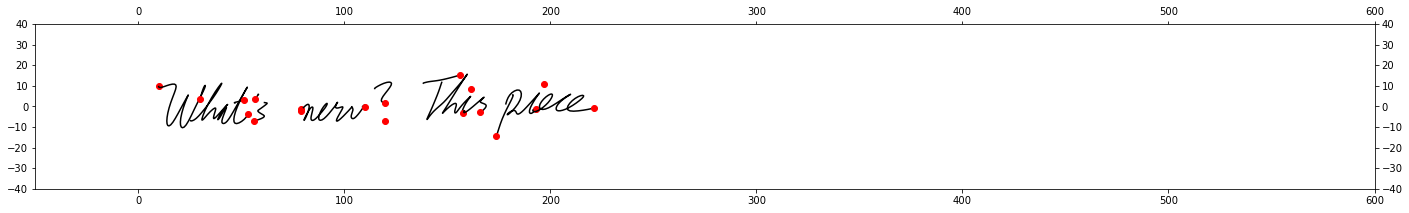

What 's new? This piece
drawing length: 674, text_length: 24


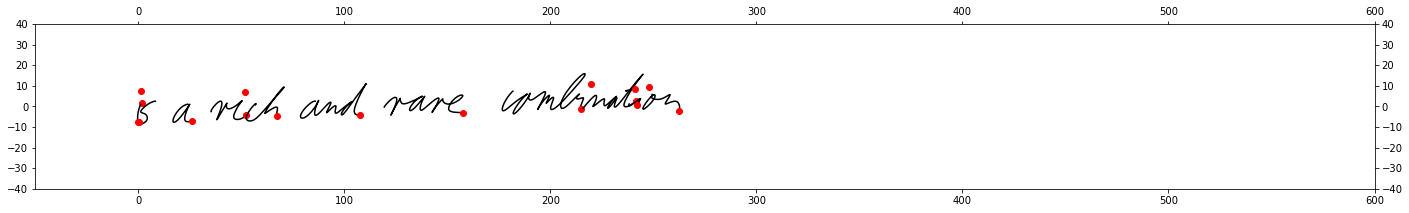

is a rich and rare combination
drawing length: 721, text_length: 31


In [5]:
for i in range(2):
    drawing.draw(strokes[i])
    print(drawing.decode_ascii(texts[i]))
    print(f"drawing length: {stroke_lens[i]}, text_length: {text_lens[i]}")

In [6]:
text_indexed = torch.tensor(texts)
max_text_len = max(text_lens)
print(max_text_len)
max_index = torch.max(text_indexed)
print(max_index)

65
tensor(72, dtype=torch.int8)


In [7]:
text_one_hots = torch.zeros((len(texts), max_text_len, max_index + 1))
text_masks = torch.ones((len(texts), max_text_len))
for i, string in enumerate(texts):
    for j, c in enumerate(string[:max_text_len]):
        text_one_hots[i, j, c] = 1
    text_masks[i, text_lens[i]:] = 0
    
text_one_hots.shape
text_masks.shape


torch.Size([11911, 65, 73])

torch.Size([11911, 65])

In [8]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [9]:
class HandwritingDataset(Dataset):
    def __init__(self,
                 strokes,
                 stroke_lengths,
                 text_one_hots,
                 text_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.text_one_hots = text_one_hots
        self.text_lengths = text_lengths
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.text_one_hots[idx], self.text_lengths[idx]
    
train_dataset = HandwritingDataset(
    strokes[:10000],
    stroke_lens[:10000],
    text_one_hots[:10000],
    text_lens[:10000])
test_dataset = HandwritingDataset(
    strokes[10000:],
    stroke_lens[10000:],
    text_one_hots[10000:],
    text_lens[10000:])

In [10]:
class HandWritingSynthesis(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_size,
                 vocab_size,
                 n_output_mixtures,
                 n_attn_mixtures):
        super(HandWritingSynthesis, self).__init__()
        # input params
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_output_mixtures = n_output_mixtures
        self.n_attn_mixtures = n_attn_mixtures
        self.vocab_size = vocab_size
        
        # inferred sizes of layer params
        self.output_size = 6*n_output_mixtures+1
        self.n_attn_params = 3*n_attn_mixtures
        
        # Layers needed
        
        # First LSTM layer
        self.lstm1 = nn.LSTMCell(
            input_size+vocab_size, hidden_size)
        
        # Layer to compute attn params from hidden state
        self.attn_params = nn.Linear(hidden_size, self.n_attn_params)
        
        # Second LSTM layer
        self.lstm2 = nn.LSTMCell(
            input_size+hidden_size+vocab_size, hidden_size)
        
        # Layer to compute params for output gaussian
        self.output_params = nn.Linear(
            2*hidden_size, self.output_size)
        
        
    def forward(self,
                stroke_point,     # (batch, input_size=3)
                text_onehot,      # (batch, max_text_len, vocab_size)
                text_length,      # (batch, 1)
                h1_prev, c1_prev, # (batch, hidden_size)
                h2_prev, c2_prev, # (batch, hidden_size)
                attn_prev,        # (batch, vocab_size)
                attn_kappa_old):  # (batch, n_attn_mixtures)
        
        # First LSTM Layer
        h1_new, c1_new = self.lstm1(
            torch.cat((stroke_point, attn_prev), dim=-1).to(device),
            (h1_prev, c1_prev))
        
        # Attention calculations
        attn_params = self.attn_params(h1_new) # (batch, n_attn_params)
        
        attn_new, attn_kappa_new, phi_new = self.calculate_attn(
            attn_params, text_onehot, text_length, attn_kappa_old) 
        
        # Second LSTM layer
        h2_new, c2_new = self.lstm2(
            torch.cat((stroke_point, h1_new, attn_new), dim=-1).to(device),
            (h2_prev, c2_prev))
        
        out_params = self.output_params(torch.cat((h1_new, h2_new), dim=-1).to(device))
        
        return out_params, h1_new, c1_new, h2_new, c2_new, attn_new, attn_kappa_new, phi_new
    
    def calculate_attn(self, attn_params, text_onehot, text_length, attn_kappa_old):
        alpha = torch.exp(attn_params[:, :self.n_attn_mixtures])
        beta = torch.exp(attn_params[:, self.n_attn_mixtures:2*self.n_attn_mixtures])
#         print(attn_kappa_old.shape)
#         print(torch.exp(attn_params[:, 2*self.n_attn_mixtures:]).shape)
        kappa = attn_kappa_old + torch.exp(attn_params[:, 2*self.n_attn_mixtures:])
        
        def get_phi(i):
#             print(beta.shape, kappa.shape, alpha.shape)
            return torch.sum(alpha * torch.exp(-beta * (kappa - i)**2), -1)
        
        max_len = torch.max(text_length)
        phi = torch.zeros(alpha.shape[0], max_len, device=device)
        for i in range(max_len):
            phi[:,i] = get_phi(i)
#         print(phi)
#         print(text_onehot[:,:max_len,:].shape)
#         print(phi.unsqueeze(-1).shape)
#         print((text_onehot[:,:max_len,:]*phi.unsqueeze(-1)).shape)
        attn = torch.sum(text_onehot[:,:max_len,:]*phi.unsqueeze(-1), axis=1)
#         print(attn)
#         print(attn.shape)
        return attn, kappa, phi
        

In [11]:
def negative_log_likelihood(batch_params,       # (batch_size, 6*n_output_mixtures+1)
                            batch_targets,      # (batch_size, 3)
                            n_output_mixtures,
                            args):  
    batch_size = batch_params.shape[0]
    
    K = args["n_output_mixtures"]

    # end of stroke probability, last colmn in the params
    es = 1/(1 + torch.exp(batch_params[:,-1]))    # (batch_size, 1)
    
    # mixture weights
    pis = nn.Softmax(1)(batch_params[:,0:K]) # (batch_size, n_output_mixtures)
    
    # Means, sigmas and correlations of the mixture gaussians
    mus = batch_params[:, K:3*K].reshape(-1, K, 2)            # (batch_size, n_output_mixtures, 2)
    sigmas = torch.exp(batch_params[:, 3*K:5*K].reshape(-1, K, 2))  # (batch_size, n_output_mixtures, 2)
    phos = torch.tanh(batch_params[:, 5*K:6*K].reshape(-1, K, 1))   # (batch_size, n_output_mixtures, 1)

    # Calculate covariance matrices for the mixture gaussians
    covs = torch.zeros(batch_size, K, 2, 2, device=args["device"])    # (batch_size, n_output_mixtures, 2, 2)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    # multivariate gaussians for each all means and covariance matrices
    distributions = torch.distributions.MultivariateNormal(mus, covs)  # (batch_size, n_output_mixtures)

    target_coords = batch_targets[:,0:2].unsqueeze(1).repeat_interleave(  
        torch.tensor([K], device=device), dim=1)           # (batch_size, n_output_mixtures, 2)
    stroke_lift = batch_targets[:,-1]                            # (batch_size, 1)

    eps = 1e-8
    probs = torch.exp(distributions.log_prob(target_coords) + eps)   # (batch_size, n_output_mixtures)
    probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)

    batch_loss = - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    return batch_loss/batch_size

In [12]:
def get_batch_sizes(strokes, stroke_lengths, text_onehots, text_lengths):
    
    stroke_lengths_sorted, perm_idx = stroke_lengths.sort(0, descending=True)
    
    strokes_sorted = strokes[perm_idx]
    text_onehots_sorted = text_onehots[perm_idx]
    text_lengths_sorted = text_lengths[perm_idx]
    
    bs = strokes.shape[0]
    num_timesteps = torch.max(stroke_lengths)-1
    
    batch_sizes = torch.tensor([bs] * num_timesteps, device=device)
    for i in range(len(stroke_lengths_sorted)-1, 0, -1):
        bs -= 1
        batch_sizes[stroke_lengths_sorted[i]-1:stroke_lengths_sorted[i-1]-1] = bs
    return strokes_sorted, stroke_lengths_sorted, text_onehots_sorted, text_lengths_sorted, batch_sizes
    

In [13]:
def train(model,
          strokes,
          stroke_lengths,
          text_onehots,
          text_lengths,
          optimizer,
          args,
          h1, c1, h2, c2, attn, attn_kappa):
    optimizer.zero_grad()
    strokes = strokes.to(args["device"])
    stroke_lengths = stroke_lengths.to(args["device"])
    text_onehots = text_onehots.to(args["device"])
    text_lengths = text_lengths.to(args["device"])
    
    # prepare so that we can handle varying length inputs in training
    strokes, stroke_lengths, text_onehots, text_lengths, batch_sizes = get_batch_sizes(
        strokes, stroke_lengths, text_onehots, text_lengths)
    
    loss = 0
    # At timestamp t, we have to look at only batch_sizes[t] entries
    for t in range(len(batch_sizes)):
        bs = batch_sizes[t]
        out_params, h1, c1, h2, c2, attn, attn_kappa, phi_new = model(
            stroke_point=strokes[:bs,t],
            text_onehot=text_onehots[:bs],
            text_length=text_lengths[:bs],
            h1_prev=h1[:bs],
            c1_prev=c1[:bs],
            h2_prev=h2[:bs],
            c2_prev=c2[:bs],
            attn_prev=attn[:bs],
            attn_kappa_old=attn_kappa[:bs])
        
        loss += negative_log_likelihood(
            out_params,
            strokes[:bs, t+1],
            args["n_output_mixtures"],
            args)
        
    loss /= len(batch_sizes)
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    return loss.item()


In [14]:
# parameters

args = {}
args["input_size"] = 3
args["hidden_size"] = 500
args["vocab_size"] = text_one_hots.shape[-1]
args["n_output_mixtures"] = 20
args["n_attn_mixtures"] = 3
args["batch_size"] = 64
args["device"] = device
args["n_epochs"] = 3
args["lr"] = 0.00001

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=args["batch_size"])
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=args["batch_size"])

model = HandWritingSynthesis(args["input_size"],
                             args["hidden_size"],
                             args["vocab_size"],
                             args["n_output_mixtures"],
                             args["n_attn_mixtures"])
model.to(device)

optim = torch.optim.Adam(model.parameters(), lr = args["lr"])

print(args["device"])

HandWritingSynthesis(
  (lstm1): LSTMCell(76, 500)
  (attn_params): Linear(in_features=500, out_features=9, bias=True)
  (lstm2): LSTMCell(576, 500)
  (output_params): Linear(in_features=1000, out_features=121, bias=True)
)

cuda:1


n_iter: 0 of 471, loss: 0.7269142627716064, timeElapsed: 18.632315635681152
n_iter: 5 of 471, loss: 3.79904522895813, timeElapsed: 98.48964309692383
n_iter: 10 of 471, loss: 3.7993022918701174, timeElapsed: 174.5193829536438
n_iter: 15 of 471, loss: 3.795704650878906, timeElapsed: 253.90698194503784
n_iter: 20 of 471, loss: 3.749520206451416, timeElapsed: 334.8432688713074
n_iter: 25 of 471, loss: 3.7875818252563476, timeElapsed: 420.2295470237732
n_iter: 30 of 471, loss: 3.713539171218872, timeElapsed: 500.20235538482666
n_iter: 35 of 471, loss: 3.6796375274658204, timeElapsed: 578.8738195896149
n_iter: 40 of 471, loss: 3.7709150314331055, timeElapsed: 662.580804347992
n_iter: 45 of 471, loss: 3.7783881187438966, timeElapsed: 748.5822176933289
n_iter: 50 of 471, loss: 3.726159620285034, timeElapsed: 821.2851731777191
n_iter: 55 of 471, loss: 3.7814633369445803, timeElapsed: 906.6061406135559
n_iter: 60 of 471, loss: 3.7164713382720946, timeElapsed: 978.1484656333923
n_iter: 65 of 471,

<Figure size 432x288 with 0 Axes>

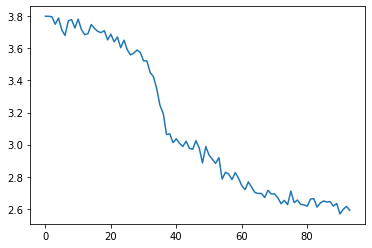

In [15]:
print_every = 5
n_iters = 0
losses = []
total_loss = 0
n_epochs = args["n_epochs"]

import time
start = time.time()

h1 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
c1 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
h2 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
c2 = torch.zeros(args["batch_size"], args["hidden_size"], device=args["device"])
attn = torch.zeros(args["batch_size"], args["vocab_size"], device=args["device"])
attn_kappa = torch.zeros(args["batch_size"], args["n_attn_mixtures"], device=args["device"])

for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 475 of 471, loss: 2.5748934745788574, timeElapsed: 7689.673203229904
n_iter: 480 of 471, loss: 2.5618300437927246, timeElapsed: 7775.193160057068
n_iter: 485 of 471, loss: 2.576872730255127, timeElapsed: 7850.638083696365
n_iter: 490 of 471, loss: 2.6140976428985594, timeElapsed: 7933.185602426529
n_iter: 495 of 471, loss: 2.573085165023804, timeElapsed: 8011.137184858322
n_iter: 500 of 471, loss: 2.5788115501403808, timeElapsed: 8096.39675951004
n_iter: 505 of 471, loss: 2.5123574256896974, timeElapsed: 8178.289010286331
n_iter: 510 of 471, loss: 2.5562945365905763, timeElapsed: 8252.605096817017
n_iter: 515 of 471, loss: 2.5897096157073975, timeElapsed: 8339.002925395966
n_iter: 520 of 471, loss: 2.565656042098999, timeElapsed: 8422.34617972374
n_iter: 525 of 471, loss: 2.513720750808716, timeElapsed: 8506.390199899673
n_iter: 530 of 471, loss: 2.5422980308532717, timeElapsed: 8581.60481595993
n_iter: 535 of 471, loss: 2.538646697998047, timeElapsed: 8660.252824783325
n_iter:

<Figure size 432x288 with 0 Axes>

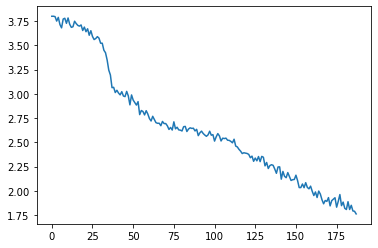

In [16]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 945 of 471, loss: 1.88204665184021, timeElapsed: 15265.168498039246
n_iter: 950 of 471, loss: 1.7299448490142821, timeElapsed: 15341.340923547745
n_iter: 955 of 471, loss: 1.770518922805786, timeElapsed: 15416.563266992569
n_iter: 960 of 471, loss: 1.741607427597046, timeElapsed: 15499.71818971634
n_iter: 965 of 471, loss: 1.7133058071136475, timeElapsed: 15586.382951259613
n_iter: 970 of 471, loss: 1.7332942247390748, timeElapsed: 15663.253954172134
n_iter: 975 of 471, loss: 1.7027399063110351, timeElapsed: 15738.043051481247
n_iter: 980 of 471, loss: 1.711767601966858, timeElapsed: 15813.80086684227
n_iter: 985 of 471, loss: 1.7395927667617799, timeElapsed: 15894.167613983154
n_iter: 990 of 471, loss: 1.7782359838485717, timeElapsed: 15977.292442798615
n_iter: 995 of 471, loss: 1.7328173160552978, timeElapsed: 16049.905509233475
n_iter: 1000 of 471, loss: 1.6884628057479858, timeElapsed: 16129.673527956009
n_iter: 1005 of 471, loss: 1.7157295227050782, timeElapsed: 16210.0603

<Figure size 432x288 with 0 Axes>

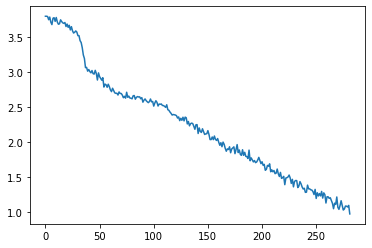

In [17]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 1415 of 1886, loss: 1.0018088817596436, timeElapsed: 22848.093880176544
n_iter: 1420 of 1891, loss: 0.9915745973587036, timeElapsed: 22924.038279771805
n_iter: 1425 of 1896, loss: 1.031467318534851, timeElapsed: 23013.799986600876
n_iter: 1430 of 1901, loss: 1.0507424116134643, timeElapsed: 23096.71730208397
n_iter: 1435 of 1906, loss: 1.0451172590255737, timeElapsed: 23180.93428182602
n_iter: 1440 of 1911, loss: 0.9701262235641479, timeElapsed: 23262.673187971115
n_iter: 1445 of 1916, loss: 0.980795705318451, timeElapsed: 23348.86967945099
n_iter: 1450 of 1921, loss: 1.0299761176109314, timeElapsed: 23417.934415578842
n_iter: 1455 of 1926, loss: 1.0823896408081055, timeElapsed: 23500.66282916069
n_iter: 1460 of 1931, loss: 0.9620455741882324, timeElapsed: 23592.241136550903
n_iter: 1465 of 1936, loss: 0.9407375574111938, timeElapsed: 23672.80699443817
n_iter: 1470 of 1941, loss: 0.9528561711311341, timeElapsed: 23751.187760591507
n_iter: 1475 of 1946, loss: 0.9821871995925904,

<Figure size 432x288 with 0 Axes>

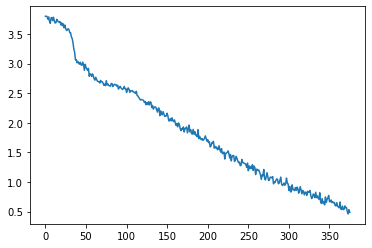

In [18]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 1885 of 2356, loss: 0.5420997619628907, timeElapsed: 30456.10136628151
n_iter: 1890 of 2361, loss: 0.5473078489303589, timeElapsed: 30545.91848564148
n_iter: 1895 of 2366, loss: 0.4826559364795685, timeElapsed: 30628.156616926193
n_iter: 1900 of 2371, loss: 0.6312890648841858, timeElapsed: 30700.714715719223
n_iter: 1905 of 2376, loss: 0.5480533361434936, timeElapsed: 30778.402988910675
n_iter: 1910 of 2381, loss: 0.5537851214408874, timeElapsed: 30861.122375249863
n_iter: 1915 of 2386, loss: 0.4601146936416626, timeElapsed: 30935.58766770363
n_iter: 1920 of 2391, loss: 0.536130428314209, timeElapsed: 31017.05371451378
n_iter: 1925 of 2396, loss: 0.39598106741905215, timeElapsed: 31097.074691295624
n_iter: 1930 of 2401, loss: 0.5380717277526855, timeElapsed: 31175.78545808792
n_iter: 1935 of 2406, loss: 0.38199182152748107, timeElapsed: 31251.818316459656
n_iter: 1940 of 2411, loss: 0.47428886890411376, timeElapsed: 31331.831967830658
n_iter: 1945 of 2416, loss: 0.4083394080400

<Figure size 432x288 with 0 Axes>

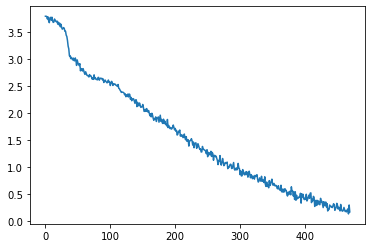

In [19]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 2355 of 2826, loss: 0.21386490315198897, timeElapsed: 38042.98903131485
n_iter: 2360 of 2831, loss: 0.22328499853610992, timeElapsed: 38124.991562366486
n_iter: 2365 of 2836, loss: 0.17946829572319983, timeElapsed: 38200.862606048584
n_iter: 2370 of 2841, loss: 0.03530009719543159, timeElapsed: 38281.04184627533
n_iter: 2375 of 2846, loss: 0.1767955332994461, timeElapsed: 38363.66030430794
n_iter: 2380 of 2851, loss: 0.20591717958450317, timeElapsed: 38442.71290421486
n_iter: 2385 of 2856, loss: 0.15331531800329684, timeElapsed: 38531.86349916458
n_iter: 2390 of 2861, loss: 0.1522633763961494, timeElapsed: 38611.75127196312
n_iter: 2395 of 2866, loss: 0.19598394967615604, timeElapsed: 38701.697279930115
n_iter: 2400 of 2871, loss: 0.07729787570424378, timeElapsed: 38777.302152872086
n_iter: 2405 of 2876, loss: 0.19754912853240966, timeElapsed: 38854.77156209946
n_iter: 2410 of 2881, loss: 0.16859350353479385, timeElapsed: 38936.76091790199
n_iter: 2415 of 2886, loss: 0.11033885

<Figure size 432x288 with 0 Axes>

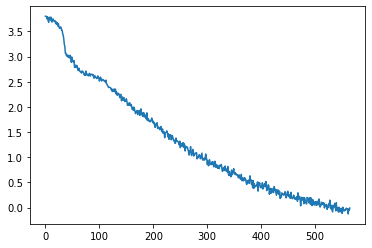

In [20]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 2830 of 3301, loss: -0.18914741296321153, timeElapsed: 45751.41916966438
n_iter: 2835 of 3306, loss: -0.11745223850011825, timeElapsed: 45836.27399921417
n_iter: 2840 of 3311, loss: -0.1263058241456747, timeElapsed: 45919.355422496796
n_iter: 2845 of 3316, loss: -0.05544737968593836, timeElapsed: 46001.20637011528
n_iter: 2850 of 3321, loss: -0.06594202672131359, timeElapsed: 46088.78437113762
n_iter: 2855 of 3326, loss: -0.0937952453037724, timeElapsed: 46167.77792406082
n_iter: 2860 of 3331, loss: -0.09822556748986244, timeElapsed: 46249.281933784485
n_iter: 2865 of 3336, loss: -0.11523879505693913, timeElapsed: 46331.7908744812
n_iter: 2870 of 3341, loss: -0.10600102543830872, timeElapsed: 46422.085762262344
n_iter: 2875 of 3346, loss: -0.10041496902704239, timeElapsed: 46503.79705762863
n_iter: 2880 of 3351, loss: -0.07991783767938614, timeElapsed: 46578.900065898895
n_iter: 2885 of 3356, loss: -0.08025388680398464, timeElapsed: 46658.9832174778
n_iter: 2890 of 3361, loss: 

<Figure size 432x288 with 0 Axes>

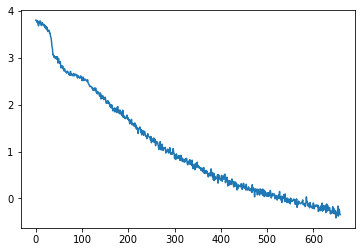

In [21]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 3300 of 3771, loss: -0.3056044578552246, timeElapsed: 54983.12731432915
n_iter: 3305 of 3776, loss: -0.3333535075187683, timeElapsed: 55063.08126497269
n_iter: 3310 of 3781, loss: -0.2797241896390915, timeElapsed: 55151.743299245834
n_iter: 3315 of 3786, loss: -0.26637119650840757, timeElapsed: 55231.65712976456
n_iter: 3320 of 3791, loss: -0.3255068719387054, timeElapsed: 55306.881340265274
n_iter: 3325 of 3796, loss: -0.31577489972114564, timeElapsed: 55385.988500118256
n_iter: 3330 of 3801, loss: -0.38880622386932373, timeElapsed: 55470.10388112068
n_iter: 3335 of 3806, loss: -0.37808485329151154, timeElapsed: 55551.00588607788
n_iter: 3340 of 3811, loss: -0.32514065504074097, timeElapsed: 55625.4396212101
n_iter: 3345 of 3816, loss: -0.35072739124298097, timeElapsed: 55703.011744976044
n_iter: 3350 of 3821, loss: -0.3335390865802765, timeElapsed: 55788.10385465622
n_iter: 3355 of 3826, loss: -0.3885535210371017, timeElapsed: 55865.52015161514
n_iter: 3360 of 3831, loss: -0.

<Figure size 432x288 with 0 Axes>

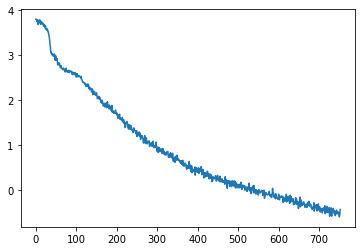

In [22]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 3770 of 4241, loss: -0.5349507510662079, timeElapsed: 62587.65067577362
n_iter: 3775 of 4246, loss: -0.45062676072120667, timeElapsed: 62672.34735751152
n_iter: 3780 of 4251, loss: -0.5054486036300659, timeElapsed: 62754.441247701645
n_iter: 3785 of 4256, loss: -0.3759891944937408, timeElapsed: 62839.42642784119
n_iter: 3790 of 4261, loss: -0.6118980586528778, timeElapsed: 62917.638755083084
n_iter: 3795 of 4266, loss: -0.5104915797710419, timeElapsed: 63001.78131580353
n_iter: 3800 of 4271, loss: -0.5845634162425994, timeElapsed: 63086.83109498024
n_iter: 3805 of 4276, loss: -0.5542421042919159, timeElapsed: 63168.36728620529
n_iter: 3810 of 4281, loss: -0.4121867597103119, timeElapsed: 63248.404992341995
n_iter: 3815 of 4286, loss: -0.5343358814716339, timeElapsed: 63330.60419178009
n_iter: 3820 of 4291, loss: -0.4650755703449249, timeElapsed: 63422.1744017601
n_iter: 3825 of 4296, loss: -0.5029701173305512, timeElapsed: 63498.83169579506
n_iter: 3830 of 4301, loss: -0.534780

<Figure size 432x288 with 0 Axes>

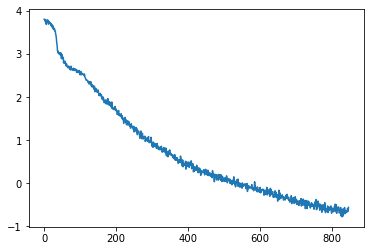

In [23]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 4240 of 4711, loss: -0.6569837212562561, timeElapsed: 70225.52207493782
n_iter: 4245 of 4716, loss: -0.6413468360900879, timeElapsed: 70308.40571475029
n_iter: 4250 of 4721, loss: -0.6308342099189759, timeElapsed: 70384.00529456139
n_iter: 4255 of 4726, loss: -0.6224593400955201, timeElapsed: 70468.34846305847
n_iter: 4260 of 4731, loss: -0.687233853340149, timeElapsed: 70549.96509337425
n_iter: 4265 of 4736, loss: -0.6825624942779541, timeElapsed: 70632.54579043388
n_iter: 4270 of 4741, loss: -0.7222957015037537, timeElapsed: 70708.23242592812
n_iter: 4275 of 4746, loss: -0.6121616125106811, timeElapsed: 70791.30051708221
n_iter: 4280 of 4751, loss: -0.6581336200237274, timeElapsed: 70875.24014782906
n_iter: 4285 of 4756, loss: -0.6459214985370636, timeElapsed: 70961.03835129738
n_iter: 4290 of 4761, loss: -0.614304494857788, timeElapsed: 71041.17749881744
n_iter: 4295 of 4766, loss: -0.7028400063514709, timeElapsed: 71121.6803677082
n_iter: 4300 of 4771, loss: -0.640697562694

<Figure size 432x288 with 0 Axes>

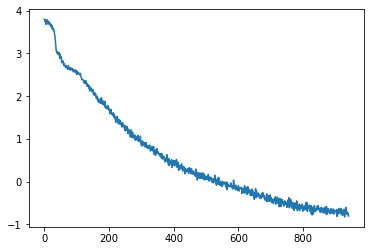

In [24]:
for i in range(args["n_epochs"]):
    for strokes, stroke_lengths, text_onehots, text_lengths in train_dataloader:
        loss = train(model,
                     strokes,
                     stroke_lengths,
                     text_onehots,
                     text_lengths,
                     optim,
                     args,
                     h1, c1, h2, c2, attn, attn_kappa)
        
        total_loss += loss
        
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_attention_bs_64.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [ ]:
def attention_plot(phis):
    plt.rcParams["figure.figsize"] = (12,6)
    phis= phis/(np.sum(phis, axis = 0, keepdims=True))
    plt.xlabel('handwriting generation')
    plt.ylabel('text scanning')
    plt.imshow(phis, cmap='hot', interpolation='nearest', aspect='auto')
    plt.show()